In [1]:
import sys
import pandas as pd
import numpy as np
from os.path import basename
from glob import glob
import h5py
import scipy.stats as ss
from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as plt
from plotnine import *
from IPython.display import display, Markdown

sys.path.insert(0, '../CODE/')
from visualization_utils import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
sys2com_dict = {x: y for x, y in np.loadtxt('../RESOURCES/Yeast_genome/orf_name_conversion.tab', dtype='str')}

# SHAP Influence of TF Binding (Calling Cards) Features for all TFs

In [3]:
perm_df = pd.read_csv('tables/SupplementalTable_CallingCards.csv')
tfs = perm_df.loc[perm_df['For SHAP analysis'], 'TF'].apply(lambda x: x.split(' ')[0])

tfb_shap_df = link_shap_to_coord_feats(
    'tf_binding', tfs,
    '../OUTPUT/yeast_cc/all_feats/',
    '../RESOURCES/Yeast_ZEV_IDEA/ZEV_15min_shrunkenData.csv',
    is_tf_dependent=True,
    coord_offset=1000, bin_width=100,
    cc_dir='../RESOURCES/Yeast_CallingCards/tss1000to500_sig/'
)

tfb_shap_df['tf_com'] = tfb_shap_df['tf'].apply(lambda x: sys2com_dict[x] if x in sys2com_dict else x)

Loading feature data ... 0 1 


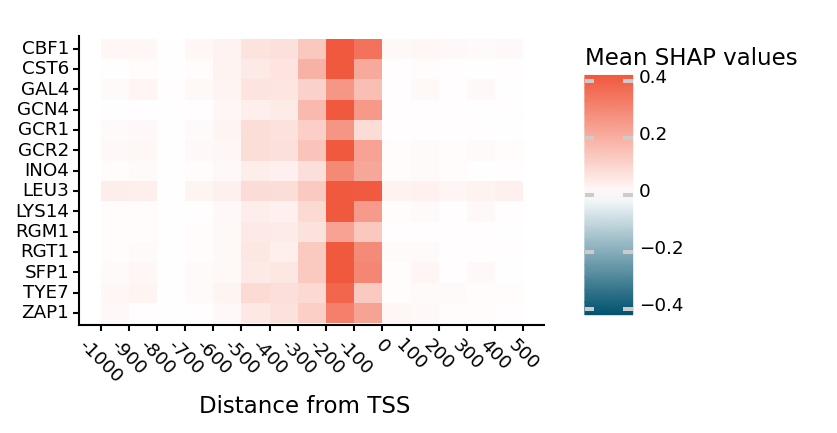

<ggplot: (-9223370633590548087)>

In [4]:
plot_df = tfb_shap_df[tfb_shap_df['is_bound'] == 'Bound'].groupby(['tf_com', 'coord'])['shap'].mean().reset_index()
plot_df['coord'] = plot_df['coord'].astype(float)
plot_df['tf_com'] = pd.Categorical(
    plot_df['tf_com'], ordered=True, categories=sorted(plot_df['tf_com'].unique())[::-1])

tf_com_ordered = sorted(plot_df['tf_com'].unique().tolist())[::-1]
plot_df['tf_com'] = pd.Categorical(plot_df['tf_com'], ordered=True, categories=tf_com_ordered)

ax = (
    ggplot(plot_df, aes(x='coord', y='tf_com', fill='shap'))
    + geom_tile()
    + scale_fill_gradientn(
        colors=[COLORS['dark_blue'], '#FFFFFF', COLORS['orange']], values=[0, 1/2, 1], limits=[-0.4, 0.4],
        name='Mean SHAP values')
    + scale_x_continuous(breaks=range(-1050, 451, 100), labels=range(-1000, 501, 100))
    + labs(x='Distance from TSS', y=None)
    + theme_classic()
    + theme(
        figure_size=(4, 2.5), dpi=150,
        axis_text_x=element_text(color='#000000', angle=-45),
        axis_text_y=element_text(color='#000000'),
        axis_ticks_minor_x=element_blank())
)
display(ax)

ax.save('figures/Yeast_CallingCards_tfb_coord_shap.pdf')

# Compare TF binding input vs SHAP values for a TF of interest

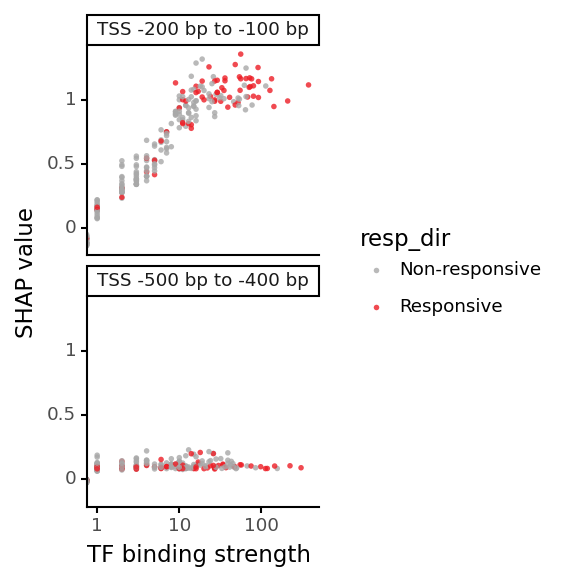

<ggplot: (-9223369042434026131)>

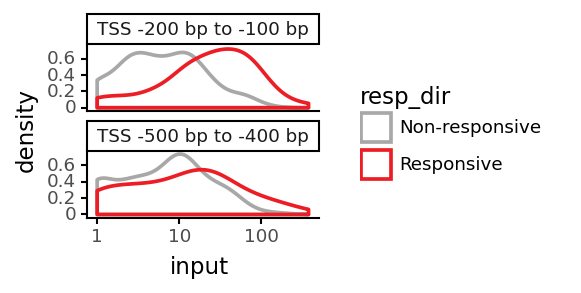

<ggplot: (-9223369042430515789)>

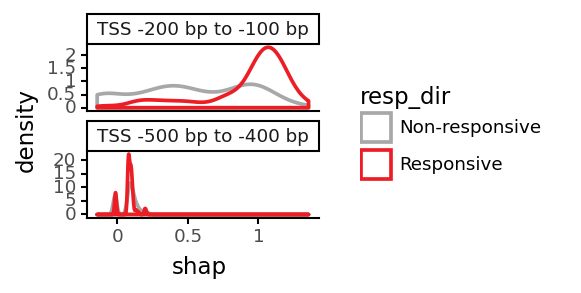

<ggplot: (-9223369042430616551)>

In [5]:
tf_of_interest = 'LEU3'
coords = [-500, -200]

plot_df = tfb_shap_df[
    (tfb_shap_df['is_bound'] == 'Bound') & \
    (tfb_shap_df['tf_com'] == tf_of_interest) & \
    (tfb_shap_df['coord'].isin(coords))]
plot_df['coord_bin'] = ['TSS {:d} bp to {:d} bp'.format(int(x), int(x) + 100) for x in plot_df['coord']]

## TFB vs SHAP
ax = (
    ggplot(plot_df, aes(x='input', y='shap', fill='resp_dir'))
    + geom_point(alpha=.8, stroke=0)
    + scale_fill_manual(values=[COLORS['grey'], COLORS['red']])
    + facet_wrap('coord_bin', ncol=1)
    + labs(x='TF binding strength', y='SHAP value')
    + scale_x_continuous(trans='log10')
    + theme_classic()
    + theme(figure_size=(2, 4), dpi=150)
)
display(ax)

ax.save('figures/Yeast_CallingCards_tfb_Leu3_input_vs_shap.pdf')


## Input TFB distribution
ax = (
    ggplot(plot_df, aes(x='input', color='resp_dir'))
    + geom_density(size=1)
    + scale_color_manual(values=[COLORS['grey'], COLORS['red']])
    + facet_wrap('coord_bin', ncol=1)
    + scale_x_continuous(trans='log10')
    + theme_classic()
    + theme(figure_size=(2, 1.5), dpi=150)
)
display(ax)

ax.save('figures/Yeast_CallingCards_tfb_Leu3_input_distribution.pdf')


## SHAP distribution
ax = (
    ggplot(plot_df, aes(x='shap', color='resp_dir'))
    + geom_density(size=1)
    + scale_color_manual(values=[COLORS['grey'], COLORS['red']])
    + facet_wrap('coord_bin', ncol=1, scales='free_y')
    + theme_classic()
    + theme(figure_size=(2, 1.5), dpi=150)
)
display(ax)

ax.save('figures/Yeast_CallingCards_tfb_Leu3_shap_distribution.pdf')

# Compare responsive vs unresponsive targets using TF binding SHAP values, for a TF of interest

In [6]:
resp_val_df = pd.DataFrame()
resp_cmp_df = pd.DataFrame()

tfb_shap_subdf = tfb_shap_df[
    (tfb_shap_df['tf_com'] == 'LEU3') & \
    (tfb_shap_df['is_bound'] == 'Bound')]

for coord, subdf in tfb_shap_subdf.groupby('coord'):
    r_vals = subdf.loc[subdf['resp_dir'] == 'Responsive', 'shap'].values
    nr_vals = subdf.loc[subdf['resp_dir'] == 'Non-responsive', 'shap'].values
    try:
        stat, p = ss.mannwhitneyu(r_vals, nr_vals)
    except:
        p = 1
        
    resp_cmp_df = resp_cmp_df.append(pd.Series({
        'coord': int(coord), 'p': p, 'r>nr': np.mean(r_vals) > np.mean(nr_vals)
        }), ignore_index=True) 
    resp_val_df = resp_val_df.append(pd.DataFrame({
        'coord': [int(coord)] * len(r_vals), 'type': ['Bound & Responsive'] * len(r_vals), 'shap': r_vals
        }), ignore_index=True) 
    resp_val_df = resp_val_df.append(pd.DataFrame({
        'coord': [int(coord)] * len(nr_vals), 'type': ['Bound & Unresponsive'] * len(nr_vals), 'shap': nr_vals
        }), ignore_index=True)
    
resp_val_df['coord'] = pd.Categorical(
    resp_val_df['coord'], ordered=True,
    categories=list(range(-1000, 501, 100)))

Significant bins
coord: -300, P-value: 0.000001
coord: -200, P-value: 0.000000
coord: -100, P-value: 0.000001
coord: 100, P-value: 0.033981
coord: 300, P-value: 0.036820


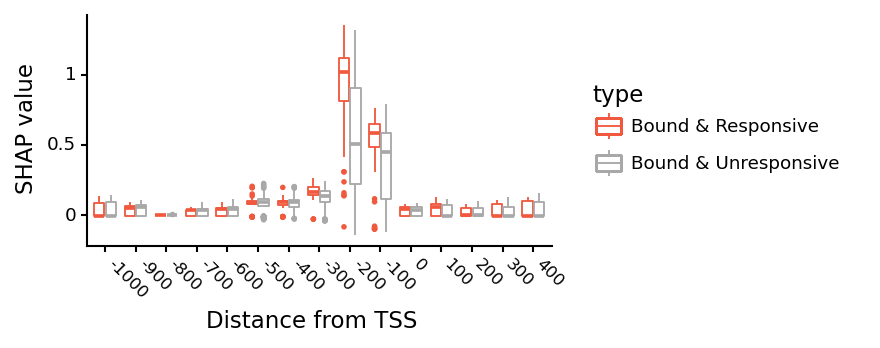

<ggplot: (2994421492309)>

In [7]:
print('Significant bins')
for _, row in resp_cmp_df.iterrows():
    if (row['p'] < 0.05) and (row['r>nr']):
        print('coord: {:d}, P-value: {:.6f}'.format(int(row['coord']), row['p']))

ax = (
    ggplot(resp_val_df, aes(x='coord', y='shap', color='type'))
    + geom_boxplot(outlier_size=.5)
    + scale_color_manual([COLORS['orange'], COLORS['grey']])
    + labs(x='Distance from TSS', y='SHAP value')
    + theme_classic()
    + theme(
        figure_size=(4, 2), dpi=150,
        axis_text_x=element_text(color='#000000', angle=-45, hjust=0, size=8),
        axis_text_y=element_text(color='#000000'))
)
display(ax)

ax.save('figures/Yeast_CallingCards_tfb_Leu3_shap_br_vs_bur.pdf')

# Compare responsive vs unresponsive targets using TF binding (Calling Cards) SHAP values, for all TFs

In [4]:
resp_cmp_df = pd.DataFrame()

for tf, tfb_shap_subdf in tfb_shap_df[tfb_shap_df['is_bound'] == 'Bound'].groupby('tf_com'):
    
    tmp_df = pd.DataFrame()
    for coord, subdf in tfb_shap_subdf.groupby('coord'):
        r_vals = subdf.loc[subdf['resp_dir'] == 'Responsive', 'shap'].values
        nr_vals = subdf.loc[subdf['resp_dir'] == 'Non-responsive', 'shap'].values
        try:
            stat, p = ss.mannwhitneyu(r_vals, nr_vals)
        except:
            p = 1
        tmp_df = tmp_df.append(pd.Series({
            'coord': coord, 'p': p, 'r>nr': np.mean(r_vals) > np.mean(nr_vals)
            }), ignore_index=True) 
        
    tmp_df['adj_p'] = multipletests(tmp_df['p'], alpha=0.05, method='hs')[1]
    tmp_df['tf_com'] = tf
    resp_cmp_df = resp_cmp_df.append(tmp_df, ignore_index=True)

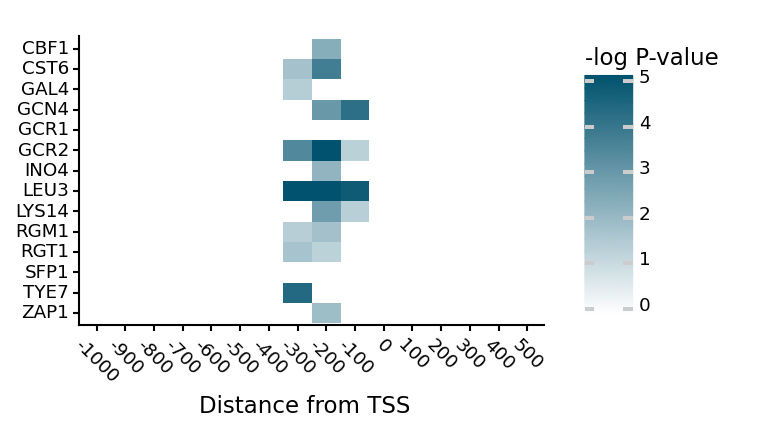

<ggplot: (1444315079695)>

In [5]:
resp_cmp_df['p_score'] = -np.log10(resp_cmp_df['adj_p'])
resp_cmp_df.loc[(resp_cmp_df['adj_p'] >= 0.05) | (resp_cmp_df['r>nr'] == False), 'p_score'] = 0

resp_cmp_df['coord'] = pd.Categorical(
    resp_cmp_df['coord'], ordered=True, categories=sorted(resp_cmp_df['coord'].unique()))
resp_cmp_df['tf_com'] = pd.Categorical(
    resp_cmp_df['tf_com'], ordered=True, categories=sorted(resp_cmp_df['tf_com'].unique())[::-1])

ax = (
    ggplot(resp_cmp_df, aes(x='coord', y='tf_com', fill='p_score'))
    + geom_tile()
    + scale_fill_gradientn(
        colors=['#FFFFFF', COLORS['dark_blue']], values=[0, 1], limits=[0, 5],
        name='-log P-value')
    + scale_x_discrete(limits=range(-1000, 501, 100))
    + labs(x='Distance from TSS', y=None)
    + theme_classic()
    + theme(
        figure_size=(4, 2.5), dpi=150,
        axis_text_x=element_text(color='#000000', angle=-45),
        axis_text_y=element_text(color='#000000'))
)
display(ax)

ax.save('figures/Yeast_CallingCards_tfb_coord_signif_shap_bins.pdf')

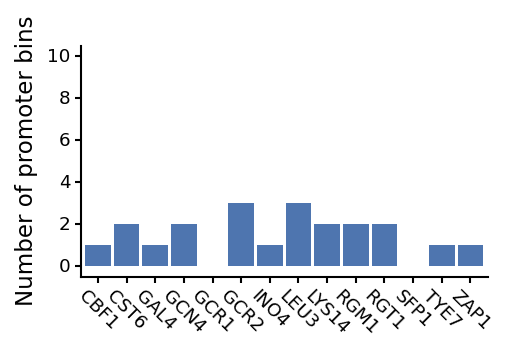

<ggplot: (1444325879293)>

In [17]:
resp_cmp_df['is_sig'] = resp_cmp_df['p_score'] > 0
resp_cnt_df = resp_cmp_df.groupby(['tf_com'])['is_sig'].sum().reset_index()
resp_cnt_df = resp_cnt_df.dropna()

resp_cnt_df['tf_com'] = pd.Categorical(
    resp_cnt_df['tf_com'], ordered=True, categories=sorted(resp_cnt_df['tf_com']))

ax = (
    ggplot(resp_cnt_df, aes(x='tf_com', y='is_sig'))
    + geom_bar(stat='identity', fill='#22529b', alpha=.8)
    + labs(y='Number of promoter bins', x=None)
    + scale_y_continuous(breaks=range(0, 11, 2), limits=[0, 10])
    + theme_classic()
    + theme(
        figure_size=(3.5, 2), dpi=150,
        axis_text_x=element_text(color='#000000', angle=-45),
        axis_text_y=element_text(color='#000000'))
)
display(ax)

ax.save('figures/Yeast_CallingCards_tfb_coord_signif_shap_bin_count.pdf')

# SHAP Influence of TF Binding (ChIP-exo) Features for all TFs

In [18]:
perm_df = pd.read_csv('tables/SupplementalTable_ChIP-exo.csv')
tfs = perm_df.loc[perm_df['For SHAP analysis'], 'TF'].apply(lambda x: x.split(' ')[0])

tfb_shap_df = link_shap_to_coord_feats(
    'tf_binding', tfs,
    '../OUTPUT/yeast_chipexo/all_feats/',
    '../RESOURCES/Yeast_ZEV_IDEA/ZEV_15min_shrunkenData.csv',
    is_tf_dependent=True,
    coord_offset=1000, bin_width=100
)

tfb_shap_df['tf_com'] = tfb_shap_df['tf'].apply(lambda x: sys2com_dict[x] if x in sys2com_dict else x)

Loading feature data ... 0 1 


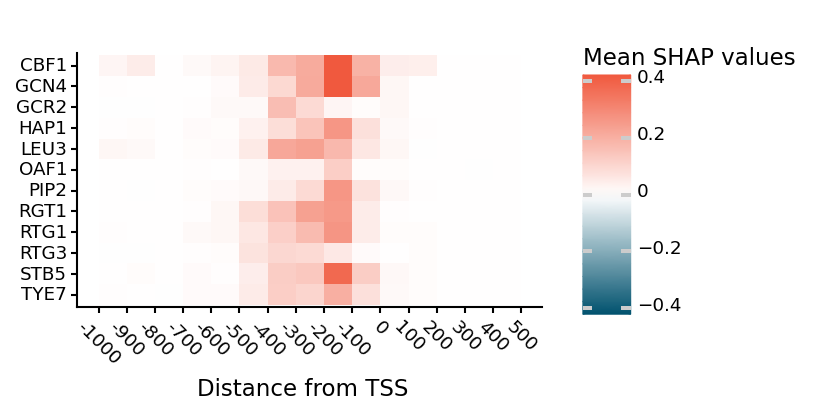

<ggplot: (2955172941011)>

In [6]:
plot_df = tfb_shap_df[tfb_shap_df['is_bound'] == 'Bound'].groupby(['tf_com', 'coord'])['shap'].mean().reset_index()
plot_df['coord'] = plot_df['coord'].astype(float)
plot_df['tf_com'] = pd.Categorical(
    plot_df['tf_com'], ordered=True, categories=sorted(plot_df['tf_com'].unique())[::-1])

tf_com_ordered = sorted(plot_df['tf_com'].unique().tolist())[::-1]
plot_df['tf_com'] = pd.Categorical(plot_df['tf_com'], ordered=True, categories=tf_com_ordered)

ax = (
    ggplot(plot_df, aes(x='coord', y='tf_com', fill='shap'))
    + geom_tile()
    + scale_fill_gradientn(
        colors=[COLORS['dark_blue'], '#FFFFFF', COLORS['orange']], values=[0, 1/2, 1], limits=[-0.4, 0.4],
        name='Mean SHAP values')
    + scale_x_continuous(breaks=range(-1050, 451, 100), labels=range(-1000, 501, 100))
    + labs(x='Distance from TSS', y=None)
    + theme_classic()
    + theme(
        figure_size=(4, 2.2), dpi=150,
        axis_text_x=element_text(color='#000000', angle=-45),
        axis_text_y=element_text(color='#000000'),
        axis_ticks_minor_x=element_blank())
)
display(ax)

ax.save('figures/Yeast_ChIPexo_tfb_coord_shap.pdf')

# Compare responsive vs unresponsive targets using TF binding (ChIP-exo) SHAP values, for all TFs

In [19]:
resp_cmp_df = pd.DataFrame()

for tf, tfb_shap_subdf in tfb_shap_df[tfb_shap_df['is_bound'] == 'Bound'].groupby('tf_com'):
    
    tmp_df = pd.DataFrame()
    for coord, subdf in tfb_shap_subdf.groupby('coord'):
        r_vals = subdf.loc[subdf['resp_dir'] == 'Responsive', 'shap'].values
        nr_vals = subdf.loc[subdf['resp_dir'] == 'Non-responsive', 'shap'].values
        try:
            stat, p = ss.mannwhitneyu(r_vals, nr_vals)
        except:
            p = 1
        tmp_df = tmp_df.append(pd.Series({
            'coord': coord, 'p': p, 'r>nr': np.mean(r_vals) > np.mean(nr_vals)
            }), ignore_index=True) 
        
    tmp_df['adj_p'] = multipletests(tmp_df['p'], alpha=0.05, method='hs')[1]
    tmp_df['tf_com'] = tf
    resp_cmp_df = resp_cmp_df.append(tmp_df, ignore_index=True)

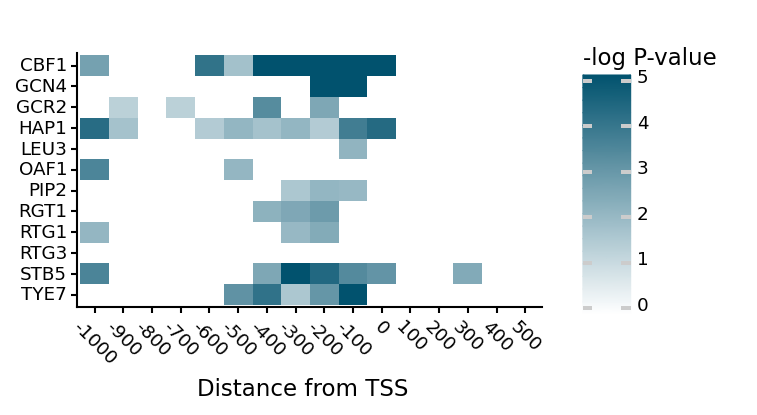

<ggplot: (1444310326136)>

In [20]:
resp_cmp_df['p_score'] = -np.log10(resp_cmp_df['adj_p'])
resp_cmp_df.loc[(resp_cmp_df['adj_p'] >= 0.05) | (resp_cmp_df['r>nr'] == False), 'p_score'] = 0

resp_cmp_df['coord'] = pd.Categorical(
    resp_cmp_df['coord'], ordered=True, categories=sorted(resp_cmp_df['coord'].unique()))
resp_cmp_df['tf_com'] = pd.Categorical(
    resp_cmp_df['tf_com'], ordered=True, categories=sorted(resp_cmp_df['tf_com'].unique())[::-1])

ax = (
    ggplot(resp_cmp_df, aes(x='coord', y='tf_com', fill='p_score'))
    + geom_tile()
    + scale_fill_gradientn(
        colors=['#FFFFFF', COLORS['dark_blue']], values=[0, 1], limits=[0, 5],
        name='-log P-value')
    + labs(x='Distance from TSS', y=None)
    + scale_x_discrete(limits=range(-1000, 501, 100))
    + theme_classic()
    + theme(
        figure_size=(4, 2.2), dpi=150,
        axis_text_x=element_text(color='#000000', angle=-45),
        axis_text_y=element_text(color='#000000'))
)
display(ax)

ax.save('figures/Yeast_ChIPexo_tfb_coord_signif_shap_bins.pdf')

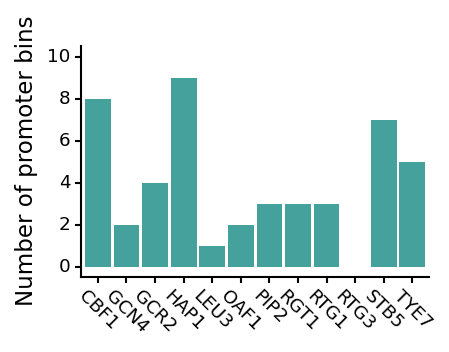

<ggplot: (1444314897647)>

In [21]:
resp_cmp_df['is_sig'] = resp_cmp_df['p_score'] > 0
resp_cnt_df = resp_cmp_df.groupby(['tf_com'])['is_sig'].sum().reset_index()
resp_cnt_df = resp_cnt_df.dropna()

resp_cnt_df['tf_com'] = pd.Categorical(
    resp_cnt_df['tf_com'], ordered=True, categories=sorted(resp_cnt_df['tf_com']))

ax = (
    ggplot(resp_cnt_df, aes(x='tf_com', y='is_sig'))
    + geom_bar(stat='identity', fill='#158a84', alpha=.8)
    + labs(y='Number of promoter bins', x=None)
    + scale_y_continuous(breaks=range(0, 11, 2), limits=[0, 10])
    + theme_classic()
    + theme(
        figure_size=(3, 2), dpi=150,
        axis_text_x=element_text(color='#000000', angle=-45),
        axis_text_y=element_text(color='#000000'))
)
display(ax)

ax.save('figures/Yeast_ChIPexo_tfb_coord_signif_shap_bin_count.pdf')